# Multi-Predator Wator Simulation
Georgia Institute of Technology

CX 4230 Spring 2019 Project 1

Maitreya Venkataswamy, Donald Dole, Wenqi He

## Introduction
This project implements the Wator simulation, originally devised by Alexander Keewatin Dewdney in 1984, with multiple predators. The predators operate in a food chain heirarchy, in which each predator can eat the organism that sits directly below it in the food chain. The simulation model itself is a Cellular Automota model, in which the moves of the organisms that occupy the cells on a 2D uniform grid with periodic boundary conditions in both directions are governed by a set of rules that were devised by Alexander Dewdney. The simulation model has been extended in this project to allow for multiple predators that follow the same rules.

### Required packages
These packages are required to run the simulations, and need to be installed before starting. Running the code below will import all te necessary packages and report to the user if there is a package missing.

In [1]:
try:
    import numpy as np
    import scipy.fftpack
except:
    print('error: need package Numpy')

try:
    %matplotlib notebook
    import matplotlib.pyplot as plt
    import matplotlib.animation as animation
    from matplotlib.widgets import Button
except:
    print('error: need package Matplotlib')
    
try:
    import pandas as pd
except:
    print('error: need package pandas')
    
try:
    from tqdm import tqdm_notebook as tqdm
except:
    print('error: need package TQDM')
    
import itertools, os, csv, warnings
warnings.filterwarnings('ignore')  # removes a few scipy/matplotlib deprecation warnings

### Seeding the random number generator [Optional]
The simulation software requires the use of a random number generator to implement the semi-random behavior of the movements of the organisms. Seeding the random number generator with a constant number allows the simulation software to produce random results that are reproducable, which makes it easier to debug the code and reproduce weird behavior when running the simuations. This step is optional, and is not required once the debugging of the software is complete.

In [2]:
np.random.seed(0)

## Simulation Framework
This simulation software makes use of a single class to allow users to initialize and run a simulation. We will begin by defining the different parts of this overall class and the methods used within.

### Classes for Prey and Predator
Before we start with the simulation class, we need to define two classes for the predators and the prey. These are simple objects that contain the information about a single organism of predator/prey type.

First is the prey object, which contains the amount of simulation time that the organism has been alive, measured in steps. The constructor also initializes a list of moves that the organism can make, given its step size. For a step size of one, the organism is restricted to moving one cell up, down, left, or right in a single simulation step. For a step size of two, this list of moves is augmented by an additional step up, down, left, or right after the first step, which increases the range of the organism. We will see later why a larger step size is important.

In [3]:
class Prey:
    def __init__(self, step_size):
        self.time_alive = 0
        self.moves = []
        for di,dj in itertools.product(range(-step_size,step_size+1),range(-step_size,step_size+1)):
            if np.abs(di) + np.abs(dj) <= step_size and np.abs(di) + np.abs(dj) > 0:
                self.moves.append([di,dj])

Next we define a predator class that defines the same time alive number as the prey, but also implements an energy level and a rank number. The energy level of a predator determines if it can survive the next step in the simulation. Every step in the simulation, the predator's energy level decreases by 1. If the energy level of a predator reaches 0, the organism dies. The predator can only gain energy by eating other organisms.

The rank of the predator determines its location in the food chain. Prey, although not explicitly stated, are considered to be rank 0, and the lowest predator is rank 1. Any higher level predator has a ranking number above 1.

Again, like the prey, we also create a list of possible moves for the predator.

In [4]:
class Predator:
    def __init__(self, rank, step_size):
        self.time_alive = 0
        self.energy = 1
        self.rank = rank
        self.moves = []
        for di,dj in itertools.product(range(-step_size,step_size+1),range(-step_size,step_size+1)):
            if np.abs(di) + np.abs(dj) <= step_size and np.abs(di) + np.abs(dj) > 0:
                self.moves.append([di,dj])

### Simulation Class Definition
We will begin by defining the class for the simulation. This class has a constructor method that takes in simulation parameters as arguments, and performs a number of steps to set up and prepare the simulation for running. We will start with explaining the parameters

`nx` - The number of cells in the x direction

`ny` - The number of cells in the x direction

`ratios` - A list or initial population ratios

The size of this list is the total number of organism types in the simulation. For example, if a simulation was being performed with two predator types, the total number of organism types, and the size of the list, would be 3. The first number in the list is the percentage of the domain that is initially occupied by the prey. The following numbers are the same parameter, but for each of the predators. Note that the sum of the all the numbers in the list cannot be more than 1.0, as this would mean that the entire domain would be more than filled up with organisms, which is impossible.

`rep_times` - A list of required steps for each organism to reproduce

Each organism in the simulation reproduces by dying and splitting into two brand new organisms. The process only occurs if the organism lives through a certain number of steps, which is the reproduction times specified in this list. Each organism type can have different reproduction times, which is why this input is implemented as a list rather than just a single integer. Note that this list needs to have the same size as `ratios`

`max_steps` - The number of steps to run the simulation for

`step_sizes` - An optional list that allows the organisms to move more than one cell during each step.

We will see much later on in the project that higher level predators become extinct very quickly if not allowed to move more freely than lower level organisms. We add the ability to allow predators to move farther during each step to attempt to find a scenario in which a multiple predator system can exist.

Apart from saving the inputs as variables that belong to the simulation, the constructor of the class also allocates arrays that represent the state of the simulation. There are three such arrays:

`map` - An array containing `object` objects, that will contain the actual predator and prey instances in each cell. 

This array is initialized to be empty, and then is populated randomly with predator and prey instances randomly using the `ratios`.

`rank_map` - An array of integers, which are the ranks of the organisms that occupy the cells. 

Prey are rank 0, and predators are rank 1 through the highest level rank. An empty cell has rank -1.

`move_map` - An array of integers, either 1 or 0, that represent if a certain cell contains an organism that has already been moved during the current turn. 

This is initialized as all zeros at the start of each step, and as each organism makes their move, the cell upon which they move to is marked with a 1. This is a simple "book-keeping" tool that helps ensure that no organism double moves during a single step.

In [ ]:
def __init__(self, nx, ny, ratios, rep_times, max_steps, step_sizes=None):
    self.nx = nx
    self.ny = ny
    self.rank_map = -np.ones((self.nx,self.ny))
    self.move_map = np.zeros((self.nx,self.ny))
    self.max_steps = max_steps
    self.map = np.empty((nx,ny), dtype=object)
    self.n_predators = len(ratios) - 1
    self.pop_hist = []
    self.rep_times = rep_times
    if step_sizes is None:
        self.step_sizes = np.ones(len(ratios), dtype=int)
    else:
        self.step_sizes = step_sizes
    probs = np.cumsum(ratios)
    for i in range(nx):
        for j in range(ny):
            p = np.random.uniform(0.0,1.0)
            for n in range(len(probs)):
                if p < probs[n]:
                    if n == 0:
                        self.map[i][j] = Prey(self.step_sizes[n])
                    else:
                        self.map[i][j] = Predator(n, self.step_sizes[n])
                    break
    self.step = 0
    self.cells = []
    for i in range(nx):
        for j in range(ny):
            self.cells.append((i, j))

### Updating the `rank_map`
We write a simple function that updates `rank_map` based on the current state of the simulation.

In [ ]:
def update_rank_map(self):
        self.rank_map[:,:] = -1
        for i in range(self.nx):
            for j in range(self.ny):
                if type(self.map[i][j]) is Prey:
                    self.rank_map[i][j] = 0
                elif type(self.map[i][j]) is Predator:
                    self.rank_map[i][j] = self.map[i][j].rank

### Helper Functions
We write a series of small helper functions that are repeatedly called during the simulation to make calculations.

`get_pops()` - This function computes the populations of each organism type at any point in the simulation.

`can_eat()` - This function takes two organisms and determines if the first organism can eat the second organism.

In [ ]:
def get_pops(self):
        pops = []
        for rank in range(self.n_predators+1):
            pops.append((self.rank_map == rank).sum())
        return pops
                
def can_eat(self, eater, meal):
    if eater.rank == 1 and type(meal) is Prey:
        return True
    elif type(meal) is Predator and eater.rank - meal.rank == 1:
        return True
    else:
        return False

### Moving Each Organism
The following function takes a cell location in the domain and moves the moves the organism in that cell based on the Wator simulation rules. The movement process is divided into two options

#### Prey Movement
The prey will move into any open cell next to it. We use the helper function to obtain the list of moves it can make, and then for each of these possible moves we see if that move is blocked by a neighboring organism. Once we have reduced the set of moves into the set of possible moves, we randomly select a move from this list an use it to move the organism into the new cell. If no neighboring cells are empty, then the organism remains in place for the step. The organism attributes are updated, and a reproduction process occurs if possible, leaving behind the new organism in the original cell.

#### Predator Movement
The predator will move into any cell next to it, provided that either the cell is open or the cell contains an organism that the predator can eat. Like the prey movement, we start by determining the moves the predator can make given its reach. Then we reduce this list by ensuring that the predator does not move into a cell that is not empty or a cell in which resides an organism that the predator cannot eat. From this reduced list of possible moves, if any of the possible moves result in the predatator eating another organism, a move is randomlt selected from this subset of possible moves so that the predator is guaranteed to eat an organism. If the predator cannot eat an organism, then it randomly moves to an open cell that it can reach. If it cannot do this, then the predator does not move. The predators attributes are updates, similarly to the prey movement process, and reproduction is handled as well.

In [ ]:
def move(self, i, j):
    self.move_map[i,j] = 1
    di, dj = 0, 0
    if type(self.map[i][j]) is Prey:
        moves = []
        for di,dj in self.map[i][j].moves:
            if self.map[(i+di)%self.nx][(j+dj)%self.ny] is None:
                moves.append((di,dj))
        if not moves:
            return
        else:
            di,dj = moves[np.random.choice(len(moves))]
            self.map[(i+di)%self.nx][(j+dj)%self.ny] = self.map[i][j]
            self.map[i][j] = None
            self.map[(i+di)%self.nx][(j+dj)%self.ny].time_alive += 1
            if self.map[(i+di)%self.nx][(j+dj)%self.ny].time_alive > self.rep_times[0]:
                self.map[i][j] = Prey(self.step_sizes[0])
                self.map[(i+di)%self.nx][(j+dj)%self.ny].time_alive = 0
    elif type(self.map[i][j]) is Predator:
        if self.map[i][j].energy == 0:
            self.map[i][j] = None
            return
        self.map[i][j].time_alive += 1
        food_moves = []
        for di,dj in self.map[i][j].moves:
            if self.can_eat(self.map[i][j], self.map[(i+di)%self.nx][(j+dj)%self.ny]):
                food_moves.append((di,dj))
        if food_moves:
            di,dj = food_moves[np.random.choice(len(food_moves))]
            self.map[(i+di)%self.nx][(j+dj)%self.ny] = self.map[i][j]
            self.map[i][j] = None
            self.map[(i+di)%self.nx][(j+dj)%self.ny].energy += 1
        else:
            reg_moves = []
            for di,dj in [[1,0],[-1,0],[0,1],[0,-1]]:
                if self.map[(i+di)%self.nx][(j+dj)%self.ny] is None:
                    reg_moves.append((di,dj))
            if not reg_moves:
                return
            else:
                di,dj = reg_moves[np.random.choice(len(reg_moves))]
                self.map[(i+di)%self.nx][(j+dj)%self.ny] = self.map[i][j]
                self.map[i][j] = None
        rank = self.map[(i+di)%self.nx][(j+dj)%self.ny].rank
        if self.map[(i+di)%self.nx][(j+dj)%self.ny].time_alive > self.rep_times[rank]:
            self.map[i][j] = Predator(rank, self.step_sizes[rank]
            self.map[(i+di)%self.nx][(j+dj)%self.ny].time_alive = 0
        self.map[(i+di)%self.nx][(j+dj)%self.ny].energy -= 1
    self.move_map[(i+di)%self.nx][(j+dj)%self.ny] = 1

### Simulation Driver
These two functions are used to drive the simulation.

`step_sim()` - This function performs a step in the simulation.

The step process involves moving each organism in the domain using the `move` function. The order in which all the organisms are moved is random, ensuring that there is no spatial bias in the simulation.

`run_simulation()` - An external function that is used by the user to actually run the simulation.

This function repeatedly calls `step_sim` until the maximum number of steps that was determined by the user is reached. By default this function will NOT animate the simulation using a 2D cell map that is colored by organism rank, but this feature can be enabled with the optional `plot`.

In [ ]:
def step_sim(self):
    self.move_map[:,:] = 0
    cells_random = np.array(self.cells)
    np.random.shuffle(cells_random)
    for i,j in cells_random:
        if self.move_map[i,j] == 0:
            self.move(i,j)
    self.step += 1
    self.move_map[:,:] = 0
    self.update_rank_map()

def run_simulation(self, plot=False):
    if plot:
        fig = plt.figure(figsize=(5,5), dpi=100)
        image = fig.gca().imshow(self.rank_map, cmap='Reds', vmin=-1, vmax=self.n_predators)
        stats = fig.gca().text(0,-0.025*self.ny,s='')

        def init():
            image.set_data(self.rank_map)
            stats.set_text('')

        def animate(i):
            self.step_sim()
            image.set_data(self.rank_map)
            stat_text = 'step %d | ' % self.step
            pops = self.get_pops()
            for n in range(len(pops)):
                stat_text += 'rank %d: %d | ' % (n,pops[n])
            self.pop_hist.append(pops.copy())
            stats.set_text(stat_text)

        return animation.FuncAnimation(fig, animate, init_func=init, frames=self.max_steps,
                                       interval=100, repeat=False)
    else:
        for _ in tqdm(range(self.max_steps)):
            self.step_sim()
            pops = self.get_pops()
            self.pop_hist.append(pops.copy())

## Final Implementation of the Simulation Class
Below is the final implementation of the simulation software in one location. The code block below represents all the code that is required to run the simulation, except for the predator and prey classes and the package imports at the beginning of the project.

In [5]:
class Simulation:
    def __init__(self, nx, ny, ratios, rep_times, max_steps, step_sizes=None):
        self.nx = nx
        self.ny = ny
        self.rank_map = -np.ones((self.nx,self.ny))
        self.move_map = np.zeros((self.nx,self.ny))
        self.max_steps = max_steps
        self.map = np.empty((nx,ny), dtype=object)
        self.n_predators = len(ratios) - 1
        self.pop_hist = []
        self.rep_times = rep_times
        if step_sizes is None:
            self.step_sizes = np.ones(len(ratios), dtype=int)
        else:
            self.step_sizes = step_sizes
        probs = np.cumsum(ratios)
        for i in range(nx):
            for j in range(ny):
                p = np.random.uniform(0.0,1.0)
                for n in range(len(probs)):
                    if p < probs[n]:
                        if n == 0:
                            self.map[i][j] = Prey(self.step_sizes[n])
                        else:
                            self.map[i][j] = Predator(n, self.step_sizes[n])
                        break
        self.step = 0
        self.cells = []
        for i in range(nx):
            for j in range(ny):
                self.cells.append((i, j))

    def get_pops(self):
        pops = []
        for rank in range(self.n_predators+1):
            pops.append((self.rank_map == rank).sum())
        return pops
                
    def can_eat(self, eater, meal):
        if eater.rank == 1 and type(meal) is Prey:
            return True
        elif type(meal) is Predator and eater.rank - meal.rank == 1:
            return True
        else:
            return False
              
    def get_move_list(self, step_size):
        moves = []
        for di,dj in itertools.product(range(-step_size,step_size+1),range(-step_size,step_size+1)):
            if np.abs(di) + np.abs(dj) <= step_size and np.abs(di) + np.abs(dj) > 0:
                moves.append([di,dj])
        return moves           
    
    def move(self, i, j):
        self.move_map[i,j] = 1
        di, dj = 0, 0
        if type(self.map[i][j]) is Prey:
            moves = []
            for di,dj in self.map[i,j].moves:
                if self.map[(i+di)%self.nx][(j+dj)%self.ny] is None:
                    moves.append((di,dj))
            if not moves:
                return
            else:
                di,dj = moves[np.random.choice(len(moves))]
                self.map[(i+di)%self.nx][(j+dj)%self.ny] = self.map[i][j]
                self.map[i][j] = None
                self.map[(i+di)%self.nx][(j+dj)%self.ny].time_alive += 1
                if self.map[(i+di)%self.nx][(j+dj)%self.ny].time_alive > self.rep_times[0]:
                    self.map[i][j] = Prey(self.step_sizes[0])
                    self.map[(i+di)%self.nx][(j+dj)%self.ny].time_alive = 0
        elif type(self.map[i][j]) is Predator:
            if self.map[i][j].energy == 0:
                self.map[i][j] = None
                return
            self.map[i][j].time_alive += 1
            food_moves = []
            for di,dj in self.map[i,j].moves:
                if self.can_eat(self.map[i][j], self.map[(i+di)%self.nx][(j+dj)%self.ny]):
                    food_moves.append((di,dj))
            if food_moves:
                di,dj = food_moves[np.random.choice(len(food_moves))]
                self.map[(i+di)%self.nx][(j+dj)%self.ny] = self.map[i][j]
                self.map[i][j] = None
                self.map[(i+di)%self.nx][(j+dj)%self.ny].energy += 1
            else:
                reg_moves = []
                for di,dj in [[1,0],[-1,0],[0,1],[0,-1]]:
                    if self.map[(i+di)%self.nx][(j+dj)%self.ny] is None:
                        reg_moves.append((di,dj))
                if not reg_moves:
                    return
                else:
                    di,dj = reg_moves[np.random.choice(len(reg_moves))]
                    self.map[(i+di)%self.nx][(j+dj)%self.ny] = self.map[i][j]
                    self.map[i][j] = None
            rank = self.map[(i+di)%self.nx][(j+dj)%self.ny].rank
            if self.map[(i+di)%self.nx][(j+dj)%self.ny].time_alive > self.rep_times[rank]:
                self.map[i][j] = Predator(rank, self.step_sizes[rank])
                self.map[(i+di)%self.nx][(j+dj)%self.ny].time_alive = 0
            self.map[(i+di)%self.nx][(j+dj)%self.ny].energy -= 1
        self.move_map[(i+di)%self.nx][(j+dj)%self.ny] = 1
        
    def update_rank_map(self):
        self.rank_map[:,:] = -1
        for i in range(self.nx):
            for j in range(self.ny):
                if type(self.map[i][j]) is Prey:
                    self.rank_map[i][j] = 0
                elif type(self.map[i][j]) is Predator:
                    self.rank_map[i][j] = self.map[i][j].rank
    
    def step_sim(self):
        self.move_map[:,:] = 0
        cells_random = np.array(self.cells)
        np.random.shuffle(cells_random)
        for i,j in cells_random:
            if self.move_map[i,j] == 0:
                self.move(i,j)
        self.step += 1
        self.move_map[:,:] = 0
        self.update_rank_map()
    
    def run_simulation(self, plot=False):
        if plot:
            fig = plt.figure(figsize=(5,5), dpi=100)
            image = fig.gca().imshow(self.rank_map, cmap='Reds', vmin=-1, vmax=self.n_predators)
            stats = fig.gca().text(0,-0.025*self.ny,s='')
        
            def init():
                image.set_data(self.rank_map)
                stats.set_text('')
            
            def animate(i):
                self.step_sim()
                image.set_data(self.rank_map)
                stat_text = 'step %d | ' % self.step
                pops = self.get_pops()
                for n in range(len(pops)):
                    stat_text += 'rank %d: %d | ' % (n,pops[n])
                self.pop_hist.append(pops.copy())
                stats.set_text(stat_text)
        
            return animation.FuncAnimation(fig, animate, init_func=init, frames=self.max_steps,
                                           interval=100, repeat=False)
        else:
            for _ in tqdm(range(self.max_steps)):
                self.step_sim()
                pops = self.get_pops()
                self.pop_hist.append(pops.copy())

### Example Usage of Simulation
Below is an example usage of the simulation software we have written. This simulation will render an animation that depicts the system evolving with time. This simulation is on a 100 x 100 grid with 25% prey and 10% predator, with  1 and 3 days to reproduce for both prey and predator respectively. This simulation is run for 100 steps with plotting enabled.


<IPython.core.display.Javascript object>


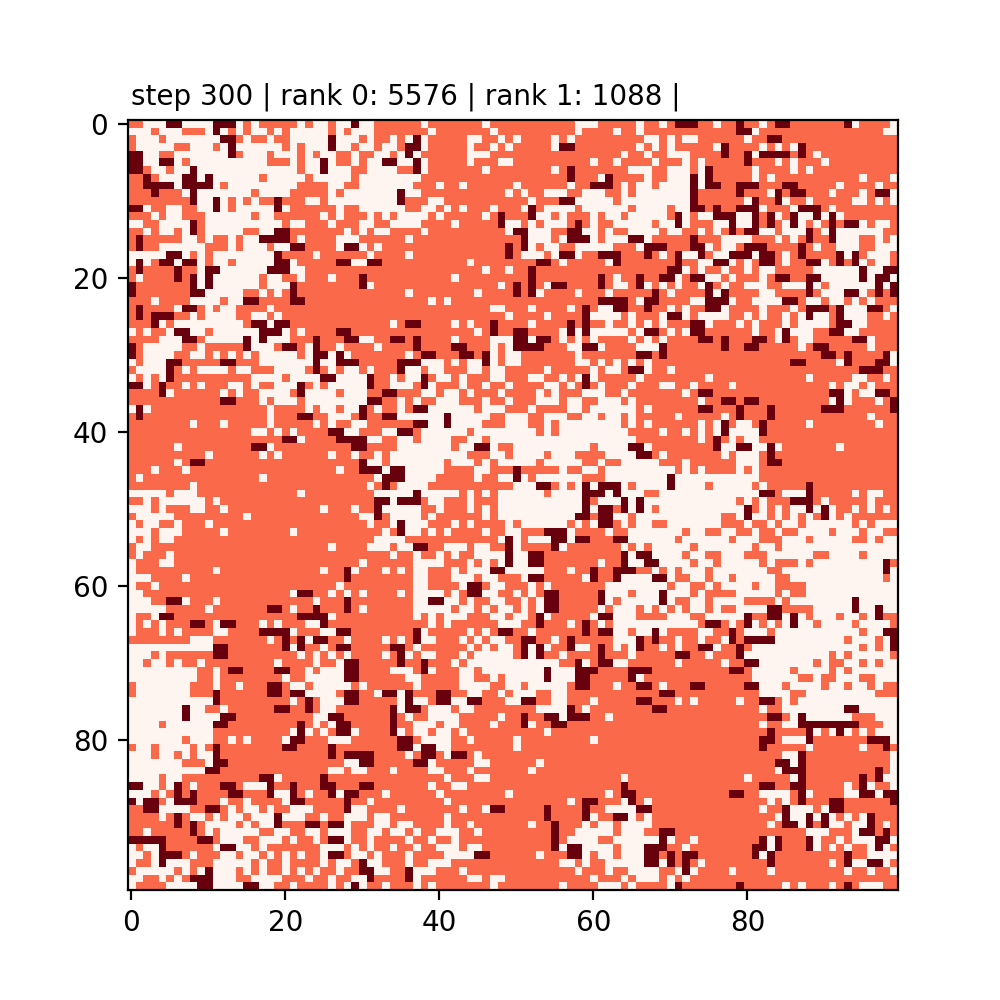

In [6]:
sim = Simulation(100,100,[0.25,0.1],[3,3],300)
sim.run_simulation(plot=True)

## Comparison to Lotka-Volterra Model

The Lotka–Volterra equations predict periodic oscillations with a delay between the population of prey and predator. However, differential equations are inherently *deterministic* and *continuous*, but our implementation has discrete state space, discrete time, and uses stochastic decisions. It cannot be determined a priori the effects of these discrepancies; on the other hand, it is also impossible to exhaust all possible initial conditions, and the necessary $\mathcal{O}(N^2)$ traversal for each iteration makes it infeasible to generate a large amount of data. Therefore, we will not attempt to answer the question as to whether there exists certain configuration that leads to what the Lotka-Volterra model predicts, although it does appear that such configuration, if exists at all, is highly unlikely.

In [7]:
N = 30
sim = Simulation(N, N, [0.6,0.2], [1,3], 500)
sim.run_simulation(plot=False)
pop_hist = np.array(sim.pop_hist)

<IPython.core.display.Javascript object>


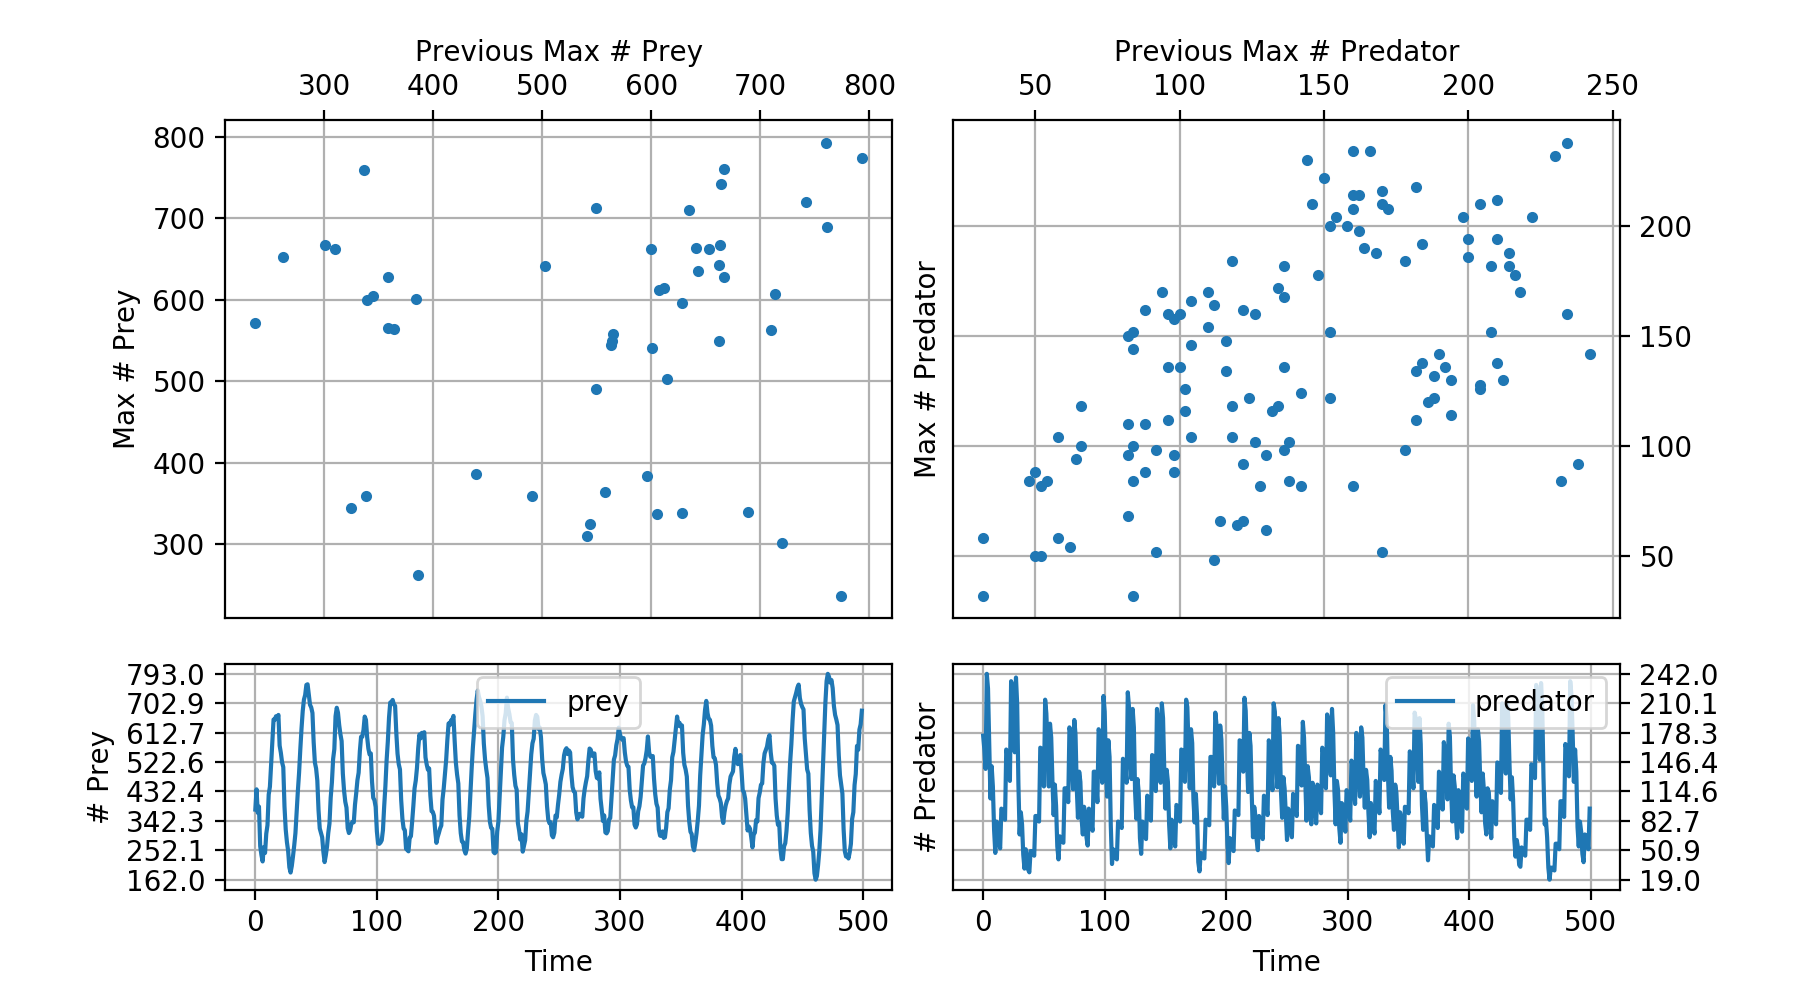

In [8]:
prey_pop = pop_hist[:,0]
predator_pop = pop_hist[:,1]
prev_prey = 0
prev_predator = 0
prev_prey_max = []
prey_max = []
prev_predator_max = []
predator_max = []

for i in range(1,len(prey_pop)-1):
    if prey_pop[i] >= prey_pop[i-1] and prey_pop[i] >= prey_pop[i+1]:
        if prev_prey != 0:
            prev_prey_max.append(prev_prey)
            prey_max.append(prey_pop[i])
        prev_prey = prey_pop[i]
    if predator_pop[i] >= predator_pop[i-1] and predator_pop[i] >= predator_pop[i+1]:
        if prev_predator != 0:
            prev_predator_max.append(prev_predator)
            predator_max.append(predator_pop[i])
        prev_predator = predator_pop[i]
        
plt.figure(figsize=(9,5))

# Plot local max against previous local max
ax = plt.subplot2grid((3,4),(0,0), colspan=2, rowspan=2)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
plt.plot(prev_prey_max, prey_max, '.')
plt.xlabel('Previous Max # Prey')
plt.ylabel('Max # Prey')
plt.grid()

# Time series of prey population
plt.subplot2grid((3,4),(2,0), colspan=2)
plt.ylabel('# Prey')
plt.xlabel('Time')
plt.plot(np.array(pop_hist)[:,0], label='prey')
plt.yticks(np.linspace(np.min(pop_hist[:,0]), np.max(pop_hist[:,0]), 8))
plt.grid()
plt.legend()

# Plot local max against previous local max
ax = plt.subplot2grid((3,4),(0,2), colspan=2, rowspan=2)
ax.yaxis.tick_right()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
plt.plot(prev_predator_max, predator_max, '.')
plt.xlabel('Previous Max # Predator')
plt.ylabel('Max # Predator')
plt.grid()

# Time series of predator population
plt.subplot2grid((3,4),(2,2), colspan=2).yaxis.tick_right()
plt.ylabel('# Predator')
plt.xlabel('Time')
plt.plot(np.array(pop_hist)[:,1], label='predator')
plt.yticks(np.linspace(np.min(pop_hist[:,1]), np.max(pop_hist[:,1]), 8))
plt.legend()
plt.grid()

As can be seen from the fluctuations in the time series, the prey and predators interact in a reasonable way: A surplus of prey leads to an increase in the number of predators, causing a subsequent decrease in prey population. After that, the population of predators drops due to a food shortage, and the population of prey population recovers. And the cycle continues.


## Classification of the Recurrent Behavior

In agreement with Lotka–Volterra model, the system always converges to a apparently oscillatory state. However, it is not obvious whether such recurrences of states are indeed periodic oscillations as the model predicts. The converging upper and lower bounds for both populations seem promising, but we still need to make further verifications. To classify the system behavior, we could use recurrence plot as a visualization technique to identify oscillations that might not be easily recognizable from the time series.



<IPython.core.display.Javascript object>


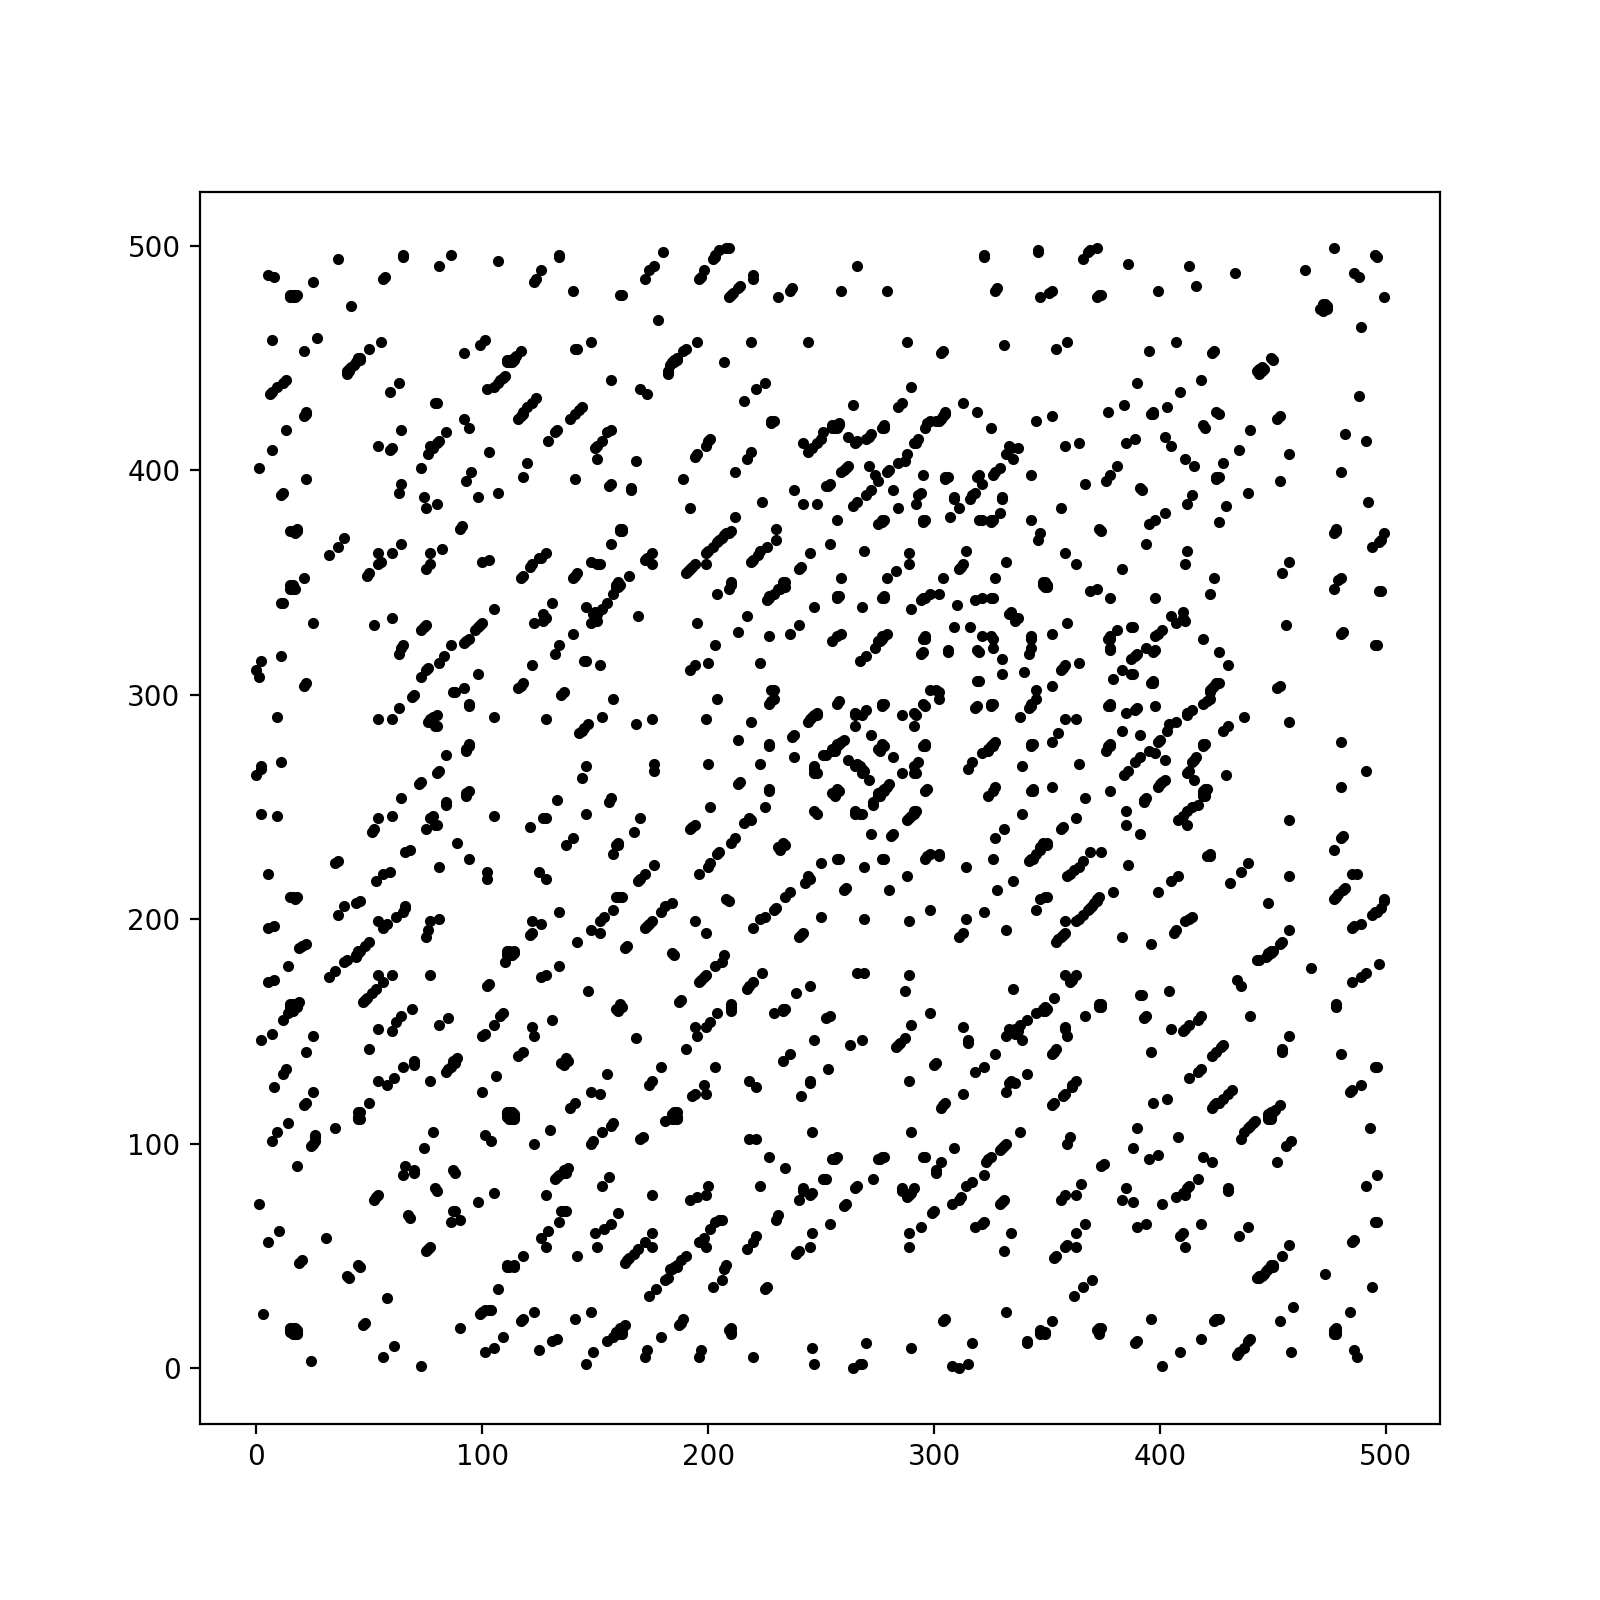

In [9]:
# Organize data
x,y = [],[]
for i in tqdm(range(len(pop_hist))):
    for j in range(i+1, len(pop_hist)):
        pop_i = np.array(pop_hist[i])
        pop_j = np.array(pop_hist[j])
        # If average distance of prey and predator at step i and j < 5
        if 0.5 * (np.linalg.norm(pop_i[0] - pop_j[0]) + np.linalg.norm(pop_i[1] - pop_j[1])) <= N**2 / 100:
            x.append(i)
            y.append(j)
            x.append(j)
            y.append(i)
            
# Recurrence plot
plt.figure(figsize=(8,8))
plt.plot(x, y, 'k.')

Although *diagonal structures* characteristic of oscillating systems can be seen throughout the plot, they are separated into tiny fragments by horizontal and vertical bands, which implies that oscillations are disrupted by anomalies that only occur due to chance, hinting at some kind of chaotic behavior. The phase portrait below confirms this speculation: The trajectory of the system moves towards an attracting region and once it is trapped it starts to skip around randomly instead of converging to a fixed point. This apprears to be a *strange attractor* typical of a chaotic system.

<IPython.core.display.Javascript object>


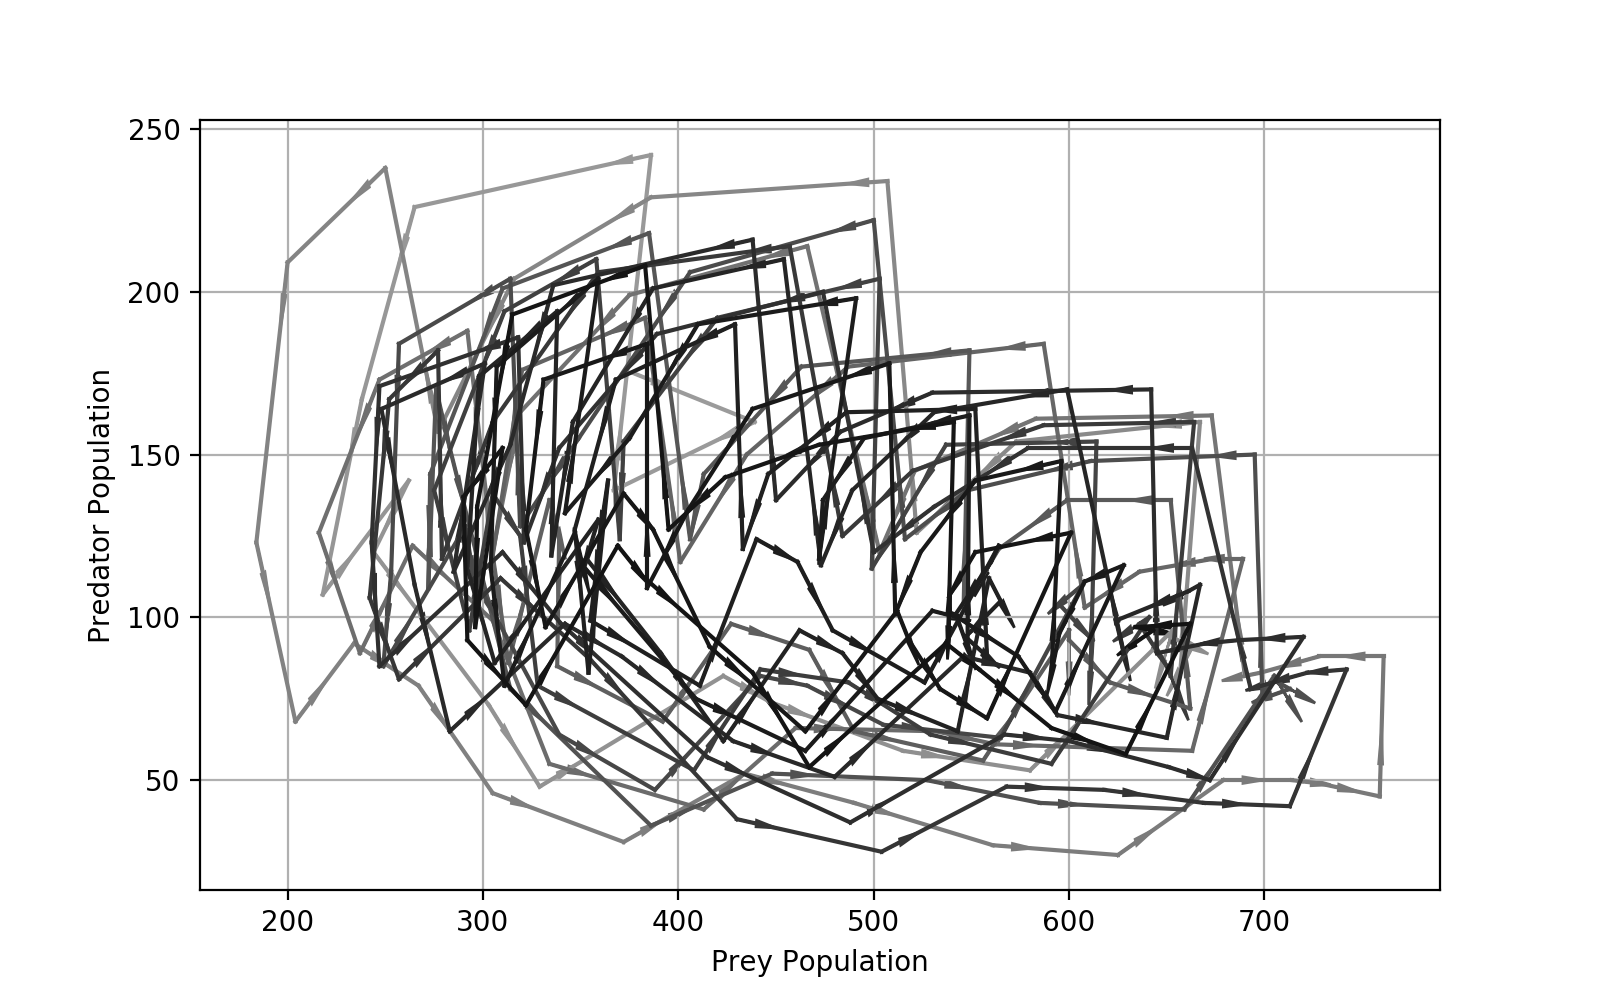

In [10]:
plt.figure(figsize=(8,5))
plt.xlabel('Prey Population')
plt.ylabel('Predator Population')
for i in range(np.minimum(len(pop_hist)-1,350)): # Draw 350 iterations max
    vec = np.array(pop_hist[i:i+10,0] - pop_hist[i:i+10,0], pop_hist[i,1]-pop_hist[i-1,1])
    norm = np.linalg.norm(vec)
    
    gs = np.exp(-(i/len(pop_hist))*3 - 0.5) # Grey scale
    
    plt.plot(pop_hist[i:i+2,0], pop_hist[i:i+2,1], '-', color=(gs,gs,gs))
    diff = pop_hist[i+1,:] - pop_hist[i,:]
    scale = np.linalg.norm(diff) / 10
    plt.arrow(pop_hist[i,0], pop_hist[i,1], diff[0]/scale, diff[1]/scale, color=(gs,gs,gs), 
        head_width=2, head_length=10)
plt.grid()
plt.show()

## Perturbation Analysis

To formally categorize the system as chaotic requires investigating the sensitivity of the system to initial conditions

### Generate random perturbation experiments

In [11]:
NX, NY, IT, D_REPR = 30, 30, 500, [1,3] # Fixed parameters
ratio = [0.9, 0.1]

# Small perturbation |d| = 0.00001
d = np.random.uniform(0.1, 0.9, 2)
d = d/np.linalg.norm(d) * 0.00001
print('Running simulation 1 [ratio = (%f, %f)]' % (ratio[0], ratio[1]))
ref_sim = Simulation(NX, NY, ratio, D_REPR, IT) 
ref_sim.run_simulation(plot=False)
print('Running simulation 2 [ratio = (%f, %f)]' % ((ratio+d)[0], (ratio+d)[1]))
pert_sim = Simulation(NX, NY, ratio+d, D_REPR, IT)
pert_sim.run_simulation(plot=False)
ref_hist = np.array(ref_sim.pop_hist)
pert_hist = np.array(pert_sim.pop_hist)

Running simulation 1 [ratio = (0.900000, 0.100000)]



Running simulation 2 [ratio = (0.900007, 0.100007)]


### Compare reference/perturbed systems

<IPython.core.display.Javascript object>


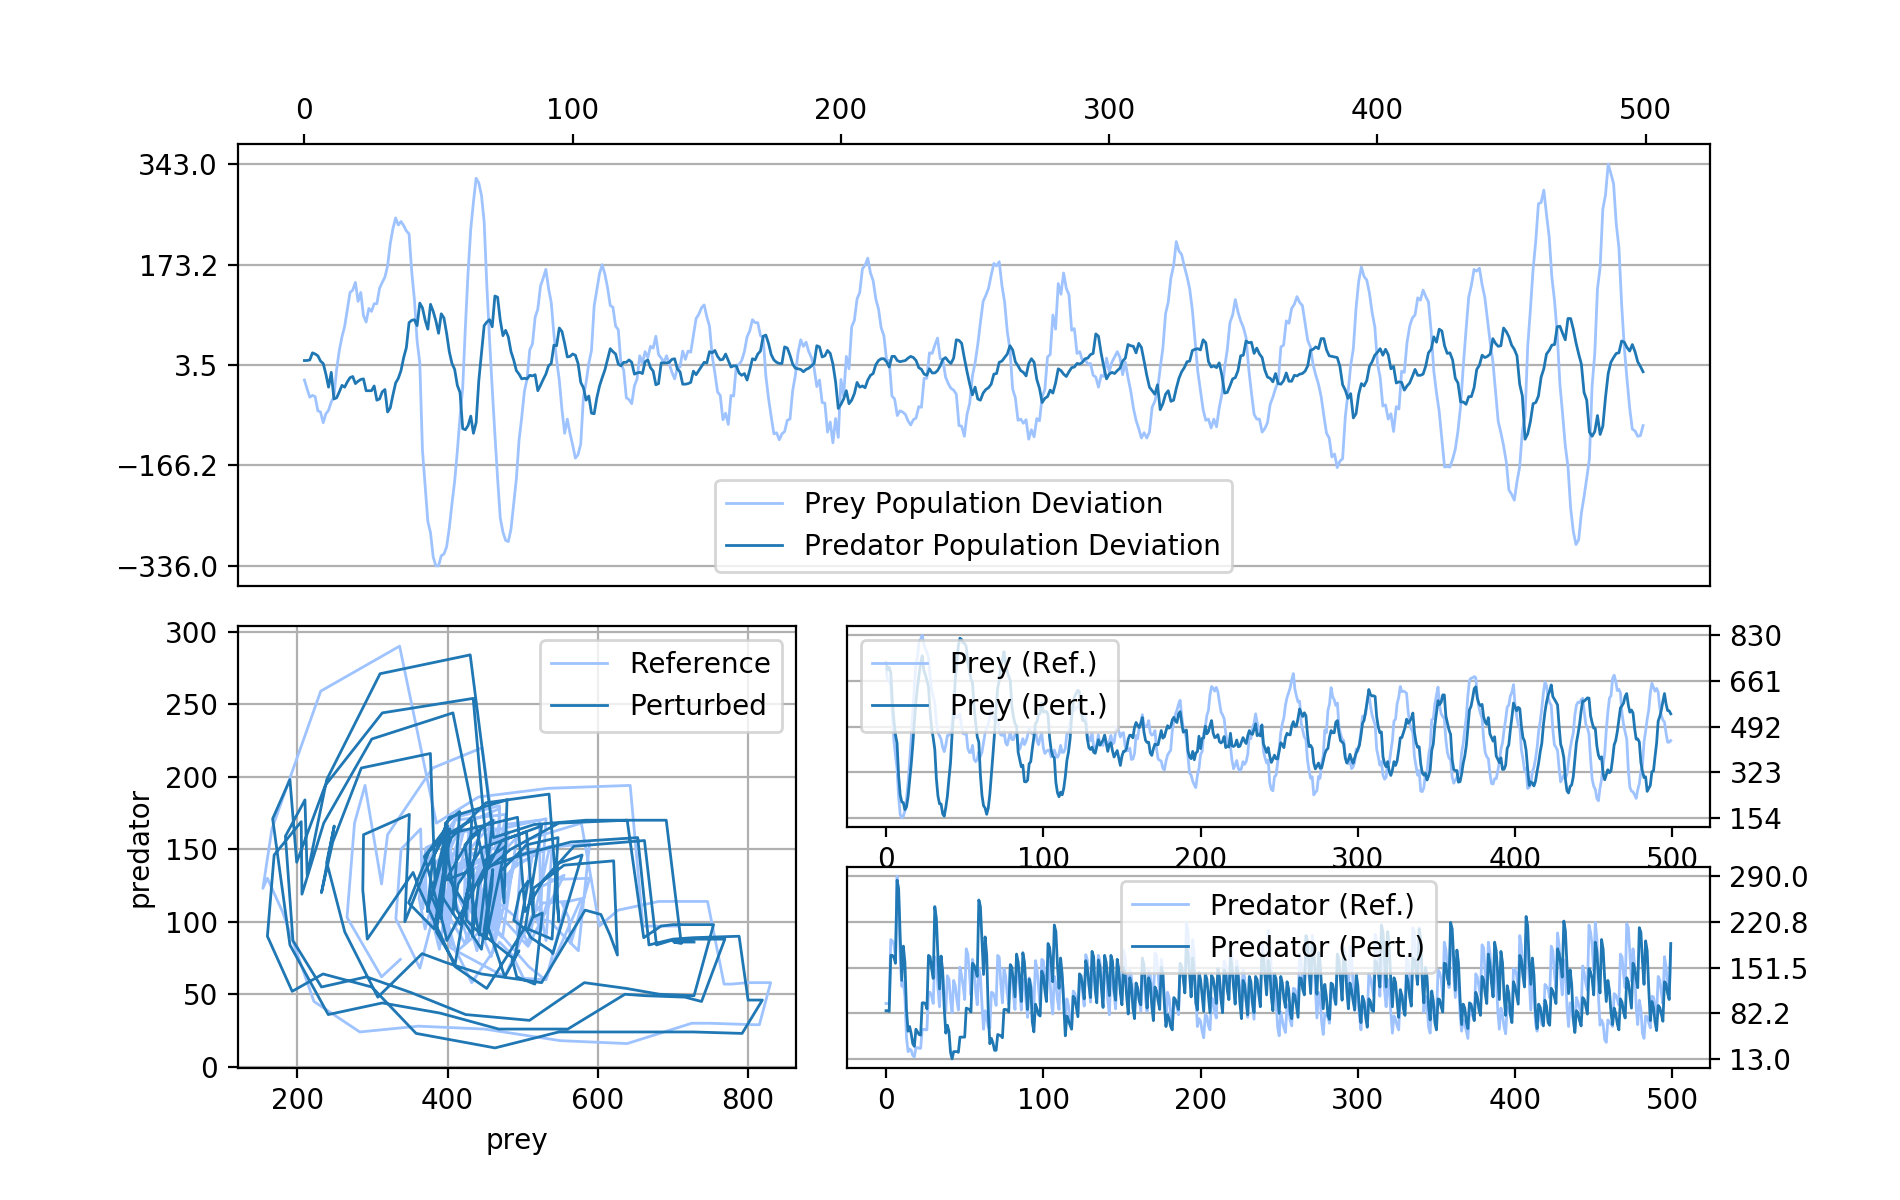

In [12]:
def plot_comparison(pop_hist):
    ref_color = (158/255,195/255,255/255)
    pert_color = (31/255,119/255,180/255)

    MAX_IT = 200

    title = 'Initial Population: ref=(%d,%d), pert=(%d,%d)' % (pop_hist[0][0], pop_hist[0][1], pop_hist[0][2], pop_hist[0][3])
    plt.figure(figsize=(9.5, 6), num=title)

    # Deviations
    ax = plt.subplot2grid((4,5),(0,0), rowspan=2, colspan=5)
    prey_dev = pop_hist[:,0] - pop_hist[:,2]
    predator_dev = pop_hist[:,1] - pop_hist[:,3]
    prey_predator_concat = np.concatenate((prey_dev, predator_dev))
    ax.xaxis.tick_top()
    plt.yticks(np.linspace(np.min(prey_predator_concat), np.max(prey_predator_concat), 5))
    plt.grid(axis='y')
    plt.plot(prey_dev, color=ref_color, label="Prey Population Deviation ",linewidth=1)
    plt.plot(predator_dev, color=pert_color, label="Predator Population Deviation", linewidth=1)
    plt.legend()

    # Phase portrait
    plt.subplot2grid((4,5),(2,0), rowspan=2, colspan=2)
    plt.plot(pop_hist[:MAX_IT,0], pop_hist[:MAX_IT,1], label="Reference", color=ref_color, linewidth=1)
    plt.plot(pop_hist[:MAX_IT,2], pop_hist[:MAX_IT,3], label="Perturbed", color=pert_color, linewidth=1)
    plt.xlabel('prey')
    plt.ylabel('predator')
    plt.grid()
    plt.legend()

    # Compare prey population
    prey_concat = np.concatenate((pop_hist[:,0], pop_hist[:,2]))
    ax = plt.subplot2grid((4,5),(2,2), colspan=3)
    ax.yaxis.tick_right()
    plt.yticks(np.linspace(np.min(prey_concat), np.max(prey_concat), 5))
    plt.grid(axis='y')
    plt.plot(pop_hist[:,0], label='Prey (Ref.)', color=ref_color, linewidth=1)
    plt.plot(pop_hist[:,2], label='Prey (Pert.)', color=pert_color, linewidth=1)
    plt.legend()

    # Compare predator population
    predator_concat = np.concatenate((pop_hist[:,1], pop_hist[:,3]))
    ax = plt.subplot2grid((4,5),(3,2), colspan=3)
    ax.yaxis.tick_right()
    plt.yticks(np.linspace(np.min(predator_concat), np.max(predator_concat), 5))
    plt.grid(axis='y')
    plt.plot(pop_hist[:,1], label='Predator (Ref.)', color=ref_color, linewidth=1)
    plt.plot(pop_hist[:,3], label='Predator (Pert.)', color=pert_color, linewidth=1)
    plt.legend()
    
plot_comparison(np.concatenate((ref_hist, pert_hist), axis=1))

In addition to confirming the existence of a strange attractor, the experiment above reveals the sensitivity of the system: As the first plot shows, a small perturbation to initial population ratio can lead to a deviation of prey population as high as 1/3 of its maximum value. This confirms that the system is indeed chaotic. The experiment also seems to suggest that the predator is somehow more resilient to initial ratio changes than the prey, which might be expected from an ecological perspective.

##  Multi-Predator Systems

The Lotka-Volterra model only concerns two state variables, but in nature there usually exist multiple levels in a food chain, thus it would be interesting to extend the simulation to one dimension higher by introducing a higher-level predator that prey on our current predators. It is reasonable to expect a similar convergence towards a overall oscillatory state that involves the interplay of all three species. However, the following experiment shows that, at least with our implementation, this situation is highly unlikely, if not impossible.

In [13]:
sim = Simulation(50,50, [.5,.3,.3], [1,1,1], 200)
sim.run_simulation(plot=False)
pop_hist = np.array(sim.pop_hist)

<IPython.core.display.Javascript object>


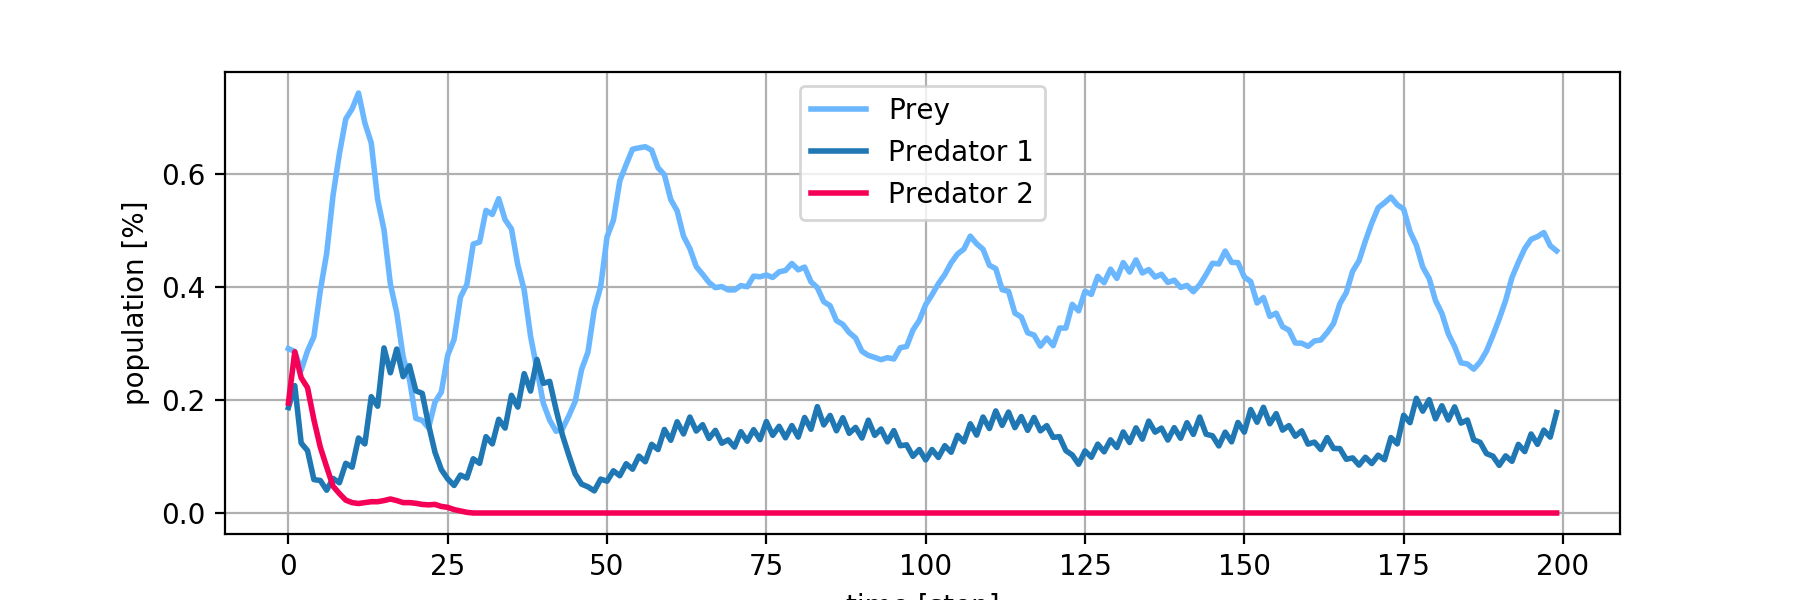

In [14]:
fig = plt.figure(figsize=(9,3))
color_predator = [(31/255,119/255,180/255), (245/255,0,87/255)]
color_prey = (106/255,183/255,255/255)

for n in range(pop_hist.shape[1]):
    if n == 0:
        plt.plot(pop_hist[:,n]/(sim.nx*sim.ny), label='Prey', color=color_prey, linewidth=2)
    else:
        plt.plot(pop_hist[:,n]/(sim.nx*sim.ny), label='Predator %d' % n, color=color_predator[n-1], linewidth=2)

plt.xlabel('time [step]')
plt.ylabel('population [%]')
plt.legend()
plt.grid()
plt.show()

It turns out that the system is extremely adverse to the new predator. We can always observe the peculiar phenomenon that, as the higher-level predator tries to eliminate the lower-level predator, it causes its own extinction. If the lower-level predators are fortunate enough to survive, the system would resume as a single-predator system. Similarly, simulations with more than two levels of predators all inevitably fall back to the single-predator case. 

### Multi-predator system - Larger Movement Considerations

On visual analysis of the multi-predator system, it seemed that the higher-level predator would either quickly kill off the intermediate predator if the inital fraction was too high, or be unable to find intermediate predators as food and die off itself. But throughout the entire simulation, it seemed like there was theoretically enough food for the second predator, but it was rarely in the right place at the right time. To attempt to mitigate this factor, the simulation was modified to allow the higher-level predator to search for food in a much larger radius. This modification allowed stable multi-predator states to be possible.

In [15]:
sim_2p = Simulation(100,100,[0.5,0.1,0.01],[3,1,10],300,step_sizes=[1,1,6])
sim_2p.run_simulation(plot=False)

<IPython.core.display.Javascript object>


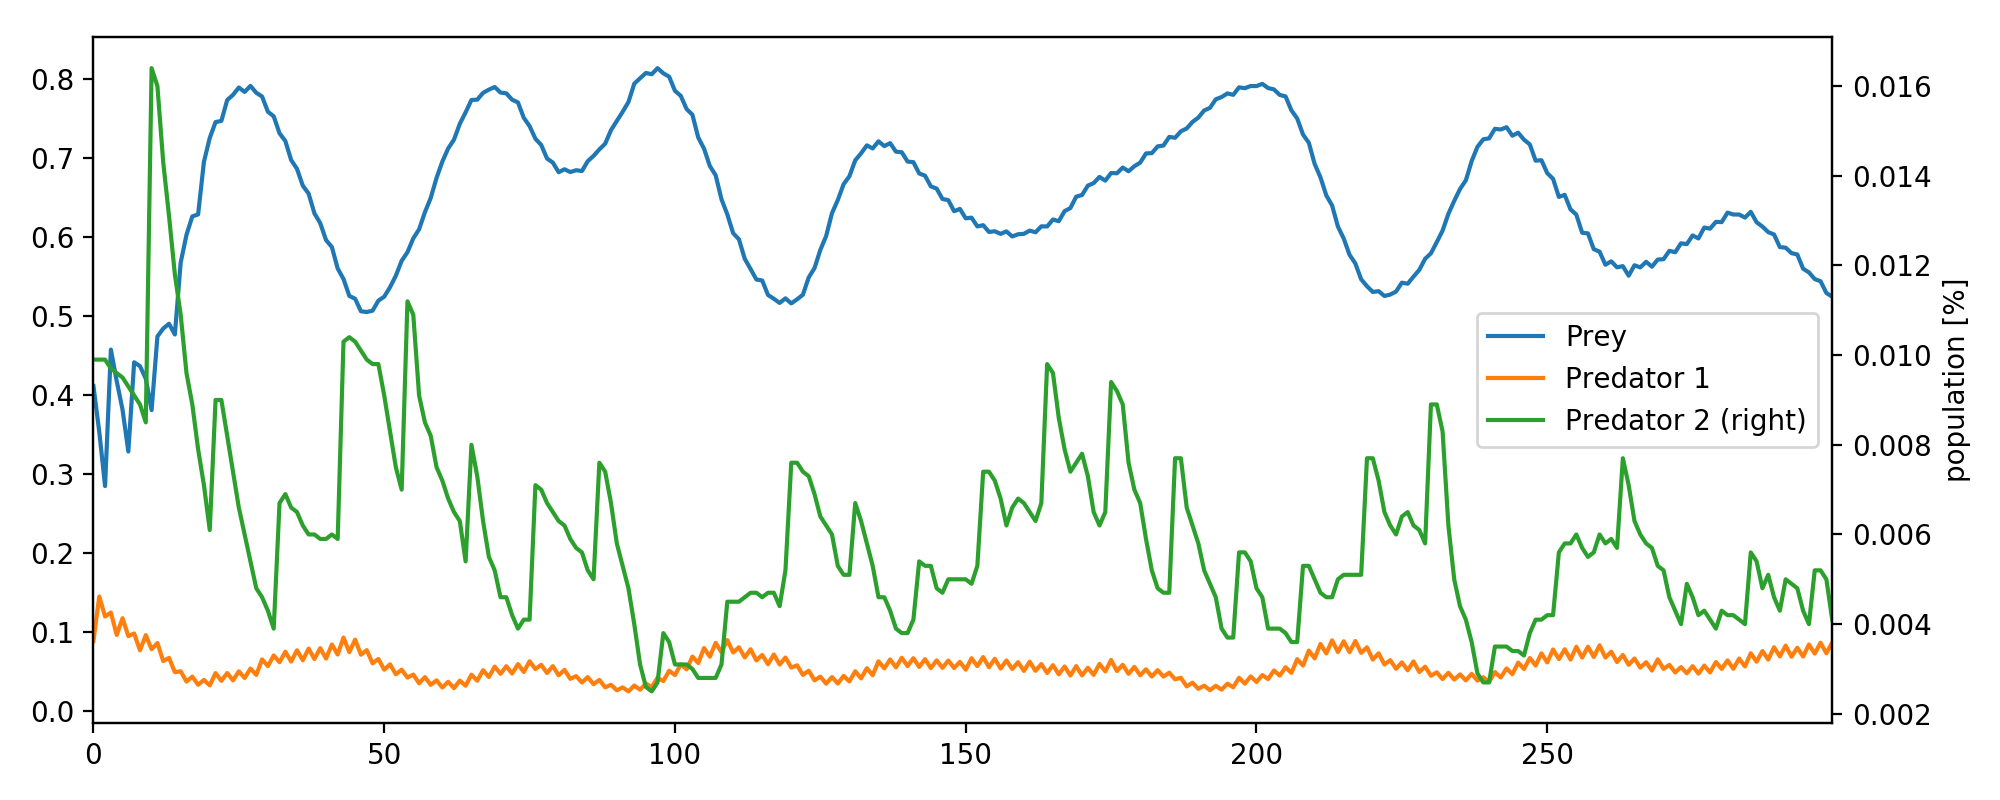

In [16]:
plt.figure(figsize=(10,4))
def two_pred_plot(sim):
    ts = pd.DataFrame(pop_hist/(sim.nx*sim.ny), columns=['Prey', 'Predator 1', 'Predator 2'])
    ts['Prey'].plot(legend=True)
    ts['Predator 1'].plot(legend=True)
    ts['Predator 2'].plot(secondary_y=True, legend=True)

    plt.xlabel('time [step]')
    plt.ylabel('population [%]')
    plt.tight_layout()
    plt.show()

pop_hist = np.array(sim_2p.pop_hist)
two_pred_plot(sim_2p)

The changes made to the simulation and initial conditions mirror the way higher-level predators work in real ecosystems. At higher levels of the food chain, there are fewer and fewer organisms. Predator 2 consistently had population levels 20 times lower than those of predator 1. Predator 2 has a much larger radius in which it can find food, representing the specialized hunting adaptations of higher-level predators. It also breeds much more slowly. Too much breeding and it kills off predator 1 and subsequently itself; too little and it's unable to maintain its own numbers.

In [17]:
p3_populations = []

def get_p3(sim):
    sim_s3.run_simulation(plot=False)
    s3_hist = np.array(sim_s3.pop_hist)
    return s3_hist[:, 2]

for s3 in [3, 5, 10]:
    sim_s3 = Simulation(100,100,[0.5,0.1,0.01],[3,1,10],300,step_sizes=[1,1,s3])
    p3_populations.append(get_p3(sim))
    
for r3 in [5, 10, 15]:
    sim_s3 = Simulation(100,100,[0.5,0.1,0.01],[3,1,r3],300,step_sizes=[1,1,6])
    p3_populations.append(get_p3(sim))

<IPython.core.display.Javascript object>


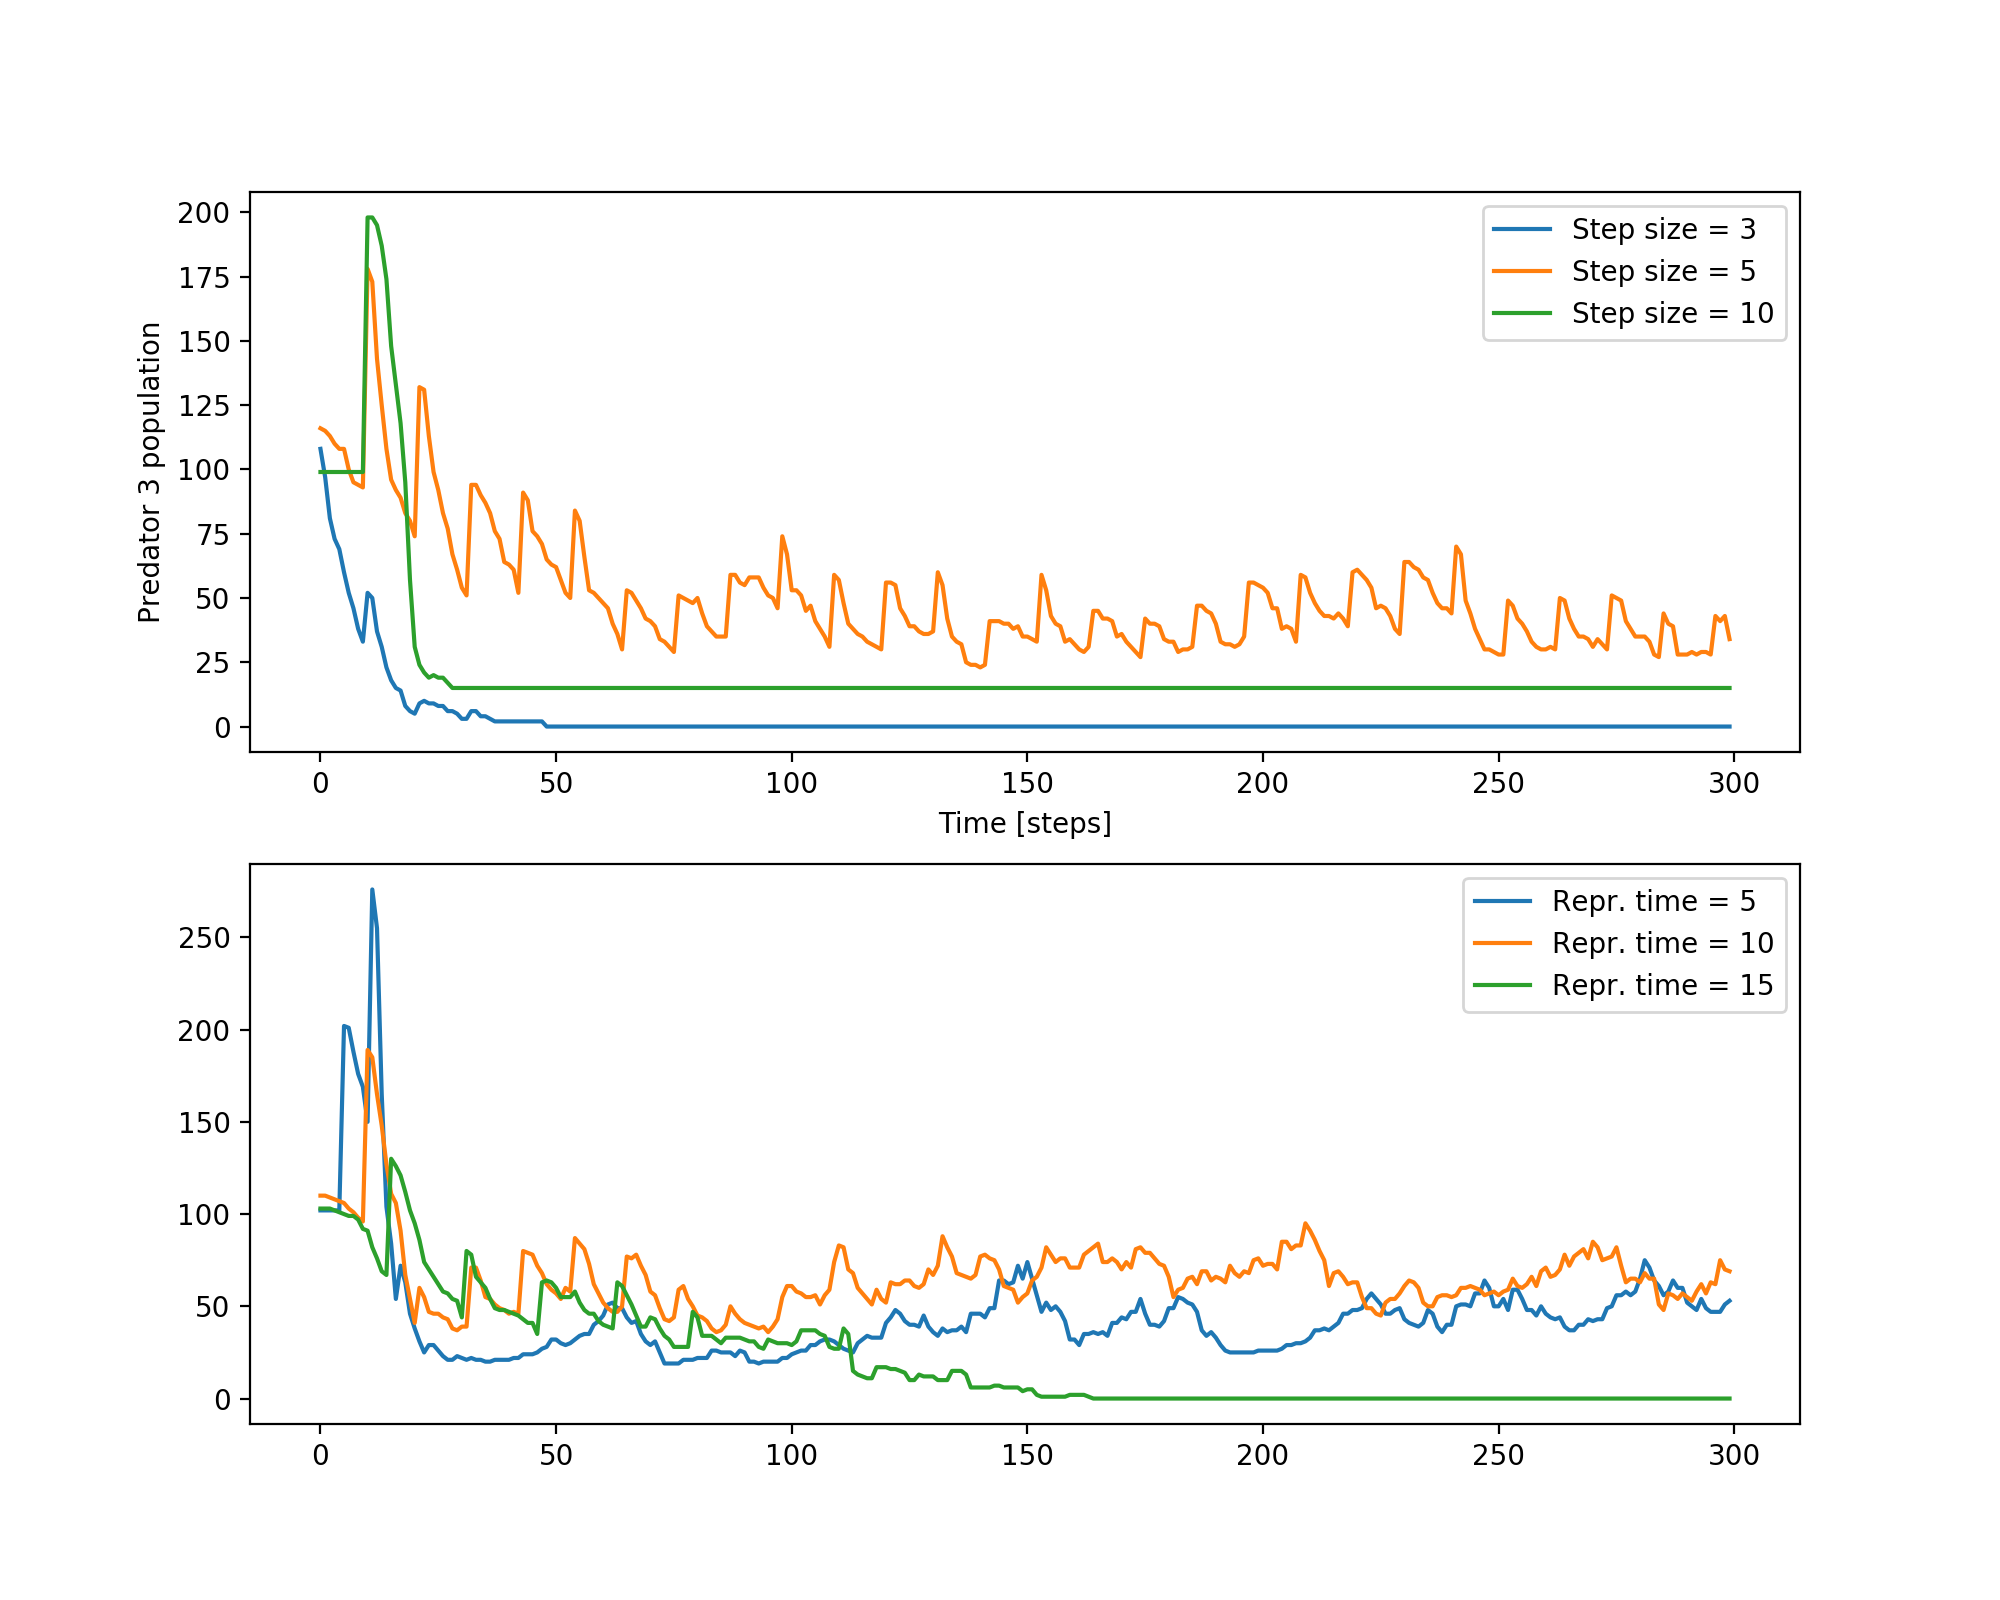

In [18]:
plt.figure(figsize=(10, 8))

plt.subplot(211)
for idx, x in enumerate([3, 5, 10]):
    plt.plot(p3_populations[idx], label='Step size = {}'.format(x))
plt.legend()
plt.xlabel('Time [steps]')
plt.ylabel('Predator 3 population')

plt.subplot(212)
for idx, x in enumerate([5, 10, 15]):
    plt.plot(p3_populations[idx + 3], label='Repr. time = {}'.format(x))
plt.legend()

plt.show()

The above charts show the instability to predators that are either too 'sedentary' or too 'voracious'. With too small a step size (the radius within which predators can eat prey), the higher-level predators are unable to survive and die off. With too large a step size, level two predators quickly eat all level one predators, leaving a field with only themselves and lowest-level prey, which they are unable to eat.

A similar scenario is true for reproduction times. A level two predator that reproduces too quickly eats all of its prey. A high reproduction time leaves the higher-level predator in a low-population but stable state.

## Frequency Analysis

The appearance of the predator-prey population plots suggests that there are harmonic components. However, it's not immediately clear which peak frequencies are the result of model parameters, and which are numerical artifacts of the simulation itself. This could be determined by observing the peak frequences while varying one parameter of the simulation. The most obvious candidate is predator and prey reproduction times.

In [19]:
pop_hist_f = []
for idx, rep in enumerate([[3,2], [4,3], [5,4], [6,5]]):
    sim_f = Simulation(100,100,[0.5,0.1],rep,300)
    sim_f.run_simulation(plot=False)
    pop_hist_f.append(np.array(sim_f.pop_hist))

In [20]:
def pop_fft(pop_hist_n, cutoff):
    N = 600
    T = 1.0 / 800.0
    x = np.linspace(0.0, N*T, N)
    y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
    yf = scipy.fftpack.fft(pop_hist_n - np.mean(pop_hist_n))
    xf = np.linspace(0, 1.0/(2.0*T), N/2)

    xf = xf[:cutoff]
    yf = yf[:cutoff]
    return xf, yf, N

def fft_plot(pop_hist, cutoff):
    for n in range(0, len(pop_hist)):
        xf, yf, N = pop_fft((pop_hist[n])[:,1], cutoff)
        label_n = 'Repr. time: [{}, {}]'.format(3+n, 2+n)
        plt.plot(xf, 2.0/N * np.abs(yf[:N//2]), label=label_n)
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>


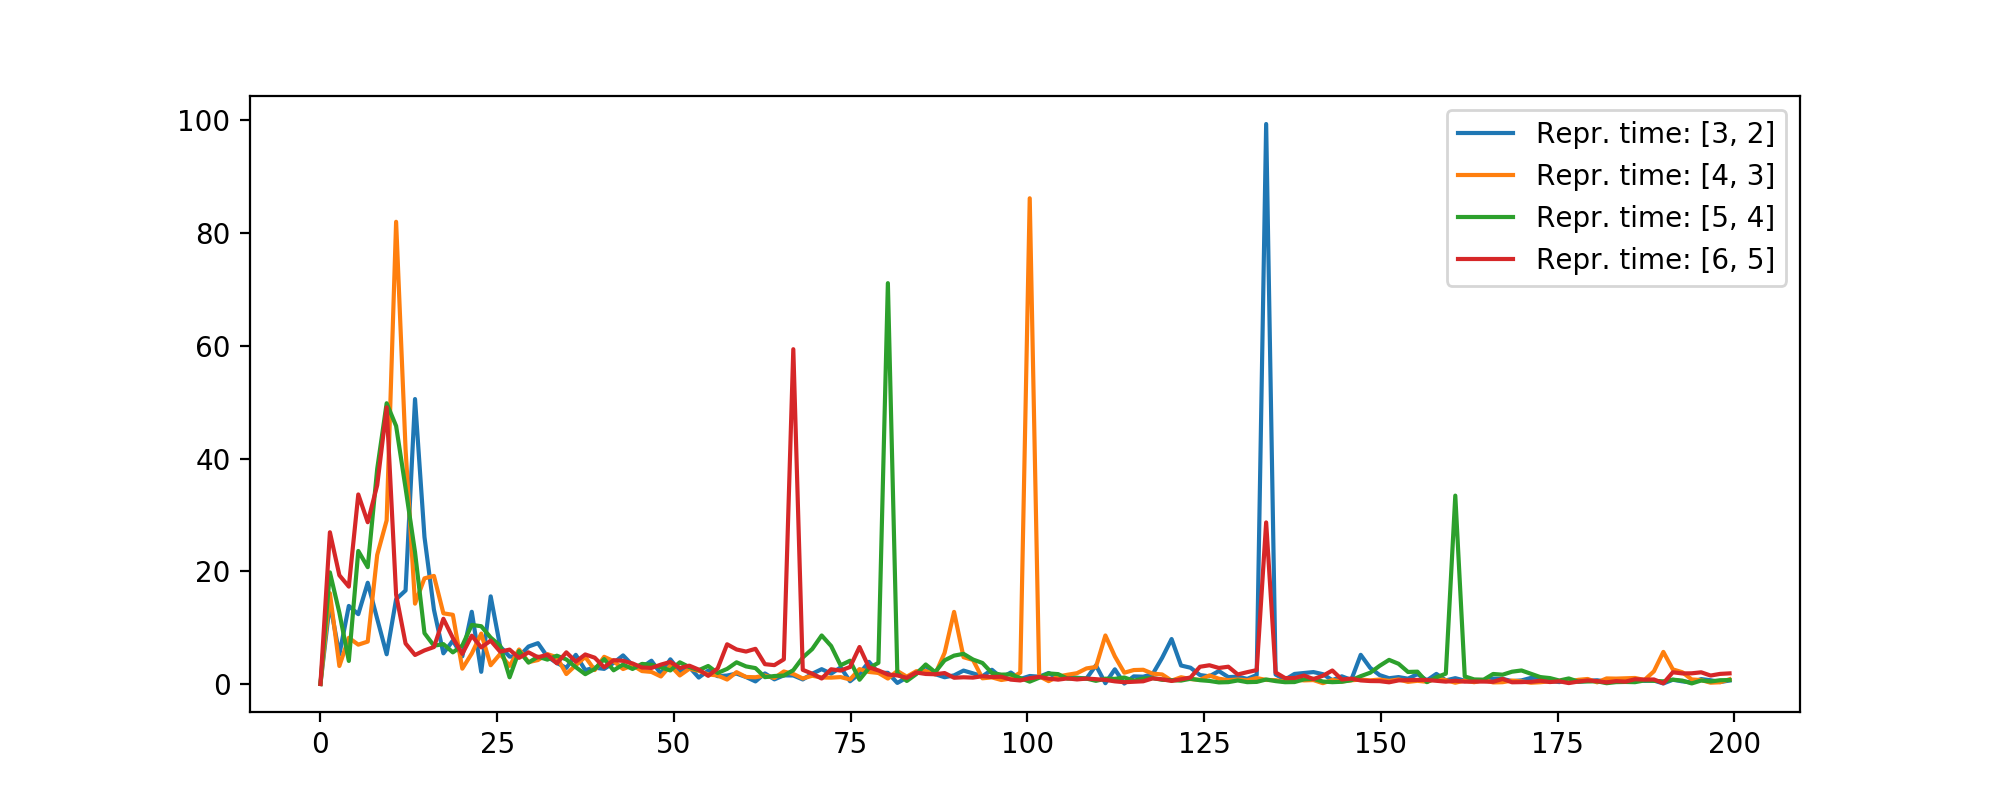

In [21]:
plt.figure(figsize=(10, 4))
fft_plot(pop_hist_f, 150)

Two predominant frequency peaks are clear. The closely clustered group of frequency peaks in the 10-15 region was influenced comparatively little by changing the simulation parameters, whereas the second group in the 50-150 region shows significant differences. This suggests that the first grouping is inherent to the simulation, while the second is influenced by the model parameters.